In [1]:
import numpy as np
import nltk
import pandas as pd
from pathlib import Path

from nltk.tag.hmm import HiddenMarkovModelTagger
from nltk import FreqDist
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt


# Import our model and the project's functions
from model.hmm import HMM
from main import get_data, per_tag_accuracy, accuracy as hmm_accuracy, evaluate_per_tag
import plots

FIG_DIR = Path("conclusions/figures")
FIG_DIR.mkdir(parents=True, exist_ok=True)


# **HIDDEN MARKOV MODEL**
Beñat Alkain, Josu Bayer, Ane Paniagua and Ander Peña

In this notebook we load and train our custom Hidden Markov Model for POS-tagging in Basque and Catalan languages. We begin by loading and analysing the UD datasets, exploring tag distributions and preparing the data for training. We then train two families of models (our custom HMM implementation and NLTK's HMM tagger), evaluate them in both test sets and compare their perfomances.

## 1. Data loading

In [2]:
# Data loading: Basque
train_sentences, train_tags = get_data("datasets/ud_basque/ud_basque_train.csv")
dev_sentences,   dev_tags   = get_data("datasets/ud_basque/ud_basque_dev.csv")
test_sentences,  test_tags  = get_data("datasets/ud_basque/ud_basque_test.csv")

print(f"# sentences in train: {len(train_sentences)}")
print(f"# sentences in dev:   {len(dev_sentences)}")
print(f"# sentences in test:  {len(test_sentences)}")

# Data loading: Catalan
train_sentences_ca, train_tags_ca = get_data("datasets/ud_catalan/ud_catalan_train.csv")
dev_sentences_ca,   dev_tags_ca   = get_data("datasets/ud_catalan/ud_catalan_dev.csv")
test_sentences_ca,  test_tags_ca  = get_data("datasets/ud_catalan/ud_catalan_test.csv")

print(f"# [CAT] sentences in train: {len(train_sentences_ca)}")
print(f"# [CAT] sentences in dev:   {len(dev_sentences_ca)}")
print(f"# [CAT] sentences in test:  {len(test_sentences_ca)}")


# sentences in train: 5396
# sentences in dev:   1798
# sentences in test:  1799
# [CAT] sentences in train: 13123
# [CAT] sentences in dev:   1709
# [CAT] sentences in test:  1846


In [3]:
print("Example sentence from the Basque train set:")
print(train_sentences[0])

print("Example sentence from the Catalan train set:")
print(train_sentences_ca[0])

Example sentence from the Basque train set:
['Gero', ',', 'lortutako', 'masa', 'molde', 'batean', 'jarri', '.']
Example sentence from the Catalan train set:
['El', 'Tribunal', 'Suprem', '(', 'TS', ')', 'ha', 'confirmat', 'la', 'condemna', 'a', 'quatre', 'anys', "d'", 'inhabilitació', 'especial', 'i', 'una', 'multa', 'de', '3,6', 'milions', 'de', 'pessetes', 'per', 'a', 'quatre', 'veterinaris', 'gironins', ',', 'per', 'haver', 'se', 'beneficiat', 'de', 'els', 'càrrecs', 'públics', 'que', 'desenvolupaven', 'i', 'la', 'seva', 'relació', 'amb', 'les', 'empreses', 'càrniques', 'de', 'la', 'zona', 'en', 'oferir', 'los', 'serveis', 'particulars', '.']


Here we compute the frequency of each POS tag in the training set of Basque.
This is directly related to the theory discussed in class:

- HMMs estimate transition and emission probabilities from tag frequencies
- Frequent tags contribute more to probability estimates
- Rare tags are more affected by data sparsity

The plotted distribution helps visualize which tags dominate the corpus and anticipate challenges during training.

Tags found: {'ADJ', 'PART', 'INTJ', 'SCONJ', 'VERB', 'ADP', 'DET', 'SYM', 'PUNCT', 'NOUN', 'CCONJ', 'NUM', 'PRON', 'ADV', 'PROPN', 'X', 'AUX'}
Total number: 17


<Axes: title={'center': 'UD tag distribution (Basque)'}, xlabel='Samples', ylabel='Counts'>

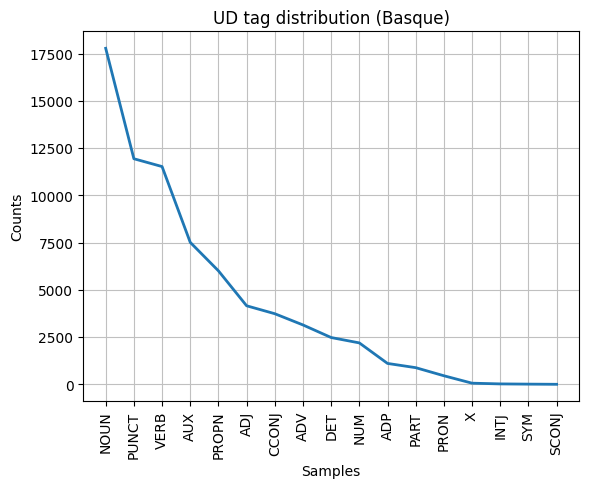

In [4]:
all_tags = [tag for sent in train_tags for tag in sent]
tagset = set(all_tags)
print("Tags found:", tagset)
print("Total number:", len(tagset))

freq = FreqDist(all_tags)
freq.plot(30, title="UD tag distribution (Basque)")


Tags found (CAT): {'ADJ', 'PART', 'INTJ', 'SCONJ', 'VERB', 'ADP', 'DET', 'SYM', 'PUNCT', 'NOUN', 'ADV', 'NUM', 'PRON', 'CCONJ', 'PROPN', 'AUX'}
Total number (CAT): 16


<Axes: title={'center': 'UD tag distribution (Catalan)'}, xlabel='Samples', ylabel='Counts'>

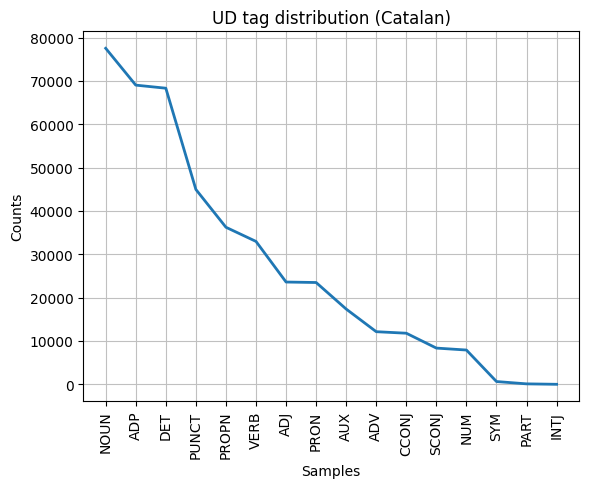

In [5]:
# Tag distribution for Catalan
all_tags_ca = [tag for sent in train_tags_ca for tag in sent]
tagset_ca = set(all_tags_ca)
print("Tags found (CAT):", tagset_ca)
print("Total number (CAT):", len(tagset_ca))

freq_ca = FreqDist(all_tags_ca)
freq_ca.plot(30, title="UD tag distribution (Catalan)")



## 2. Hidden Markov Models for POS Tagging (Basque & Catalan)

This section trains two different HMM-based POS taggers for Basque and Catalan:

- **NLTK’s HiddenMarkovModelTagger**, which requires each sentence to be a list of `(word, tag)` pairs  
- **Our custom HMM implementation**, which takes `train_sentences` (lists of words) and `train_tags` (lists of POS tags)

---

### 2.1 Data Preparation

NLTK expects labeled sequences in the form:

\[
[(w_1, t_1), (w_2, t_2), \ldots, (w_n, t_n)]
\]

Therefore, we rebuild:

- `labeled_train_eu` from `train_sentences` and `train_tags`
- `labeled_train_ca` from `train_sentences_ca` and `train_tags_ca`

NLTK then estimates:

- **Transition probabilities**
  \[
  P(y_i \mid y_{i-1})
  \]

- **Emission probabilities**
  \[
  P(x_i \mid y_i)
  \]

- **Initial probabilities**, extracted from sentence-initial tags

---

### 2.2 Our Custom HMM

Our own HMM uses the classical generative model:

\[
P(X, Y) = P(y_1) 
\prod_{i=2}^{n} P(y_i \mid y_{i-1})
\prod_{i=1}^{n} P(x_i \mid y_i)
\]

Training proceeds in two steps:

**a. Counting**

- tag-to-tag transitions  
- tag-to-word emissions  
- sentence starts via a special token `*`  
- `STOP` transitions  
- vocabulary and tag counts  

**b. Maximum Likelihood Estimation (MLE)**

Transition probabilities:

\[
P(y_i \mid y_{i-1}) = 
\frac{\text{count}(y_{i-1} \rightarrow y_i)}
     {\sum_{y'} \text{count}(y_{i-1} \rightarrow y')}
\]

Emission probabilities:

\[
P(x_i \mid y_i) = 
\frac{\text{count}(y_i \rightarrow x_i)}
     {\sum_{x'} \text{count}(y_i \rightarrow x')}
\]

---

### 2.3 Decoding with Viterbi

To predict tags, both the Basque and Catalan models use our Viterbi implementation.

**Initialization**

\[
V_1(y) = P(y \mid *) \cdot P(x_1 \mid y)
\]

**Recursion**

\[
V_t(y) = 
\left[
\max_{y'} \, V_{t-1}(y') \cdot P(y \mid y')
\right]
\cdot P(x_t \mid y)
\]

**Termination**

\[
V_n(y) \cdot P(\text{STOP} \mid y)
\]

**Backtracking** recovers the most probable tag sequence.





In [6]:
# Build labeled sequences for Basque
labeled_train_eu = [list(zip(words, tags)) for words, tags in zip(train_sentences,    train_tags)]
labeled_dev_eu   = [list(zip(words, tags)) for words, tags in zip(dev_sentences,      dev_tags)]
labeled_test_eu  = [list(zip(words, tags)) for words, tags in zip(test_sentences,     test_tags)]

# Build labeled sequences for Catalan
labeled_train_ca = [list(zip(words, tags)) for words, tags in zip(train_sentences_ca, train_tags_ca)]
labeled_dev_ca   = [list(zip(words, tags)) for words, tags in zip(dev_sentences_ca,   dev_tags_ca)]
labeled_test_ca  = [list(zip(words, tags)) for words, tags in zip(test_sentences_ca,  test_tags_ca)]


# HMM (NLTK) for Basque
tagger_eu = HiddenMarkovModelTagger.train(labeled_train_eu)

# HMM (NLTK) for Catalan
tagger_ca = HiddenMarkovModelTagger.train(labeled_train_ca)


# Our HMM for Basque
hmm_eu = HMM()
hmm_eu.train(train_sentences=train_sentences, train_tags=train_tags)

# Our HMM for Catalan
hmm_ca = HMM()
hmm_ca.train(train_sentences=train_sentences_ca, train_tags=train_tags_ca)


## 3. Evaluation

### 3.1 Token-level accuracy
We first evaluate the model using **token-level accuracy**, defined as:

\[
\text{accuracy} = 
\frac{\text{number of correctly predicted tags}}
{\text{total number of tags}}
\]

In [7]:
# ==== Accuracy of the NLTK HMM (Basque) ====
acc_train_nltk_eu = tagger_eu.accuracy(labeled_train_eu)
acc_dev_nltk_eu   = tagger_eu.accuracy(labeled_dev_eu)
acc_test_nltk_eu  = tagger_eu.accuracy(labeled_test_eu)

print(f"[NLTK HMM EU] Train accuracy: {acc_train_nltk_eu:.4f}")
print(f"[NLTK HMM EU] Dev accuracy:   {acc_dev_nltk_eu:.4f}")
print(f"[NLTK HMM EU] Test accuracy:  {acc_test_nltk_eu:.4f}")


# ==== Accuracy of the NLTK HMM (Catalan) ====
acc_train_nltk_ca = tagger_ca.accuracy(labeled_train_ca)
acc_dev_nltk_ca   = tagger_ca.accuracy(labeled_dev_ca)
acc_test_nltk_ca  = tagger_ca.accuracy(labeled_test_ca)

print(f"[NLTK HMM CA] Train accuracy: {acc_train_nltk_ca:.4f}")
print(f"[NLTK HMM CA] Dev accuracy:   {acc_dev_nltk_ca:.4f}")
print(f"[NLTK HMM CA] Test accuracy:  {acc_test_nltk_ca:.4f}")


# ==== Accuracy of our custom HMM (Basque) ====
acc_train_ours_eu = hmm_accuracy(hmm_eu, train_sentences, train_tags)
acc_dev_ours_eu   = hmm_accuracy(hmm_eu, dev_sentences,   dev_tags)
acc_test_ours_eu  = hmm_accuracy(hmm_eu, test_sentences,  test_tags)

print(f"[Our HMM EU] Train accuracy: {acc_train_ours_eu:.4f}")
print(f"[Our HMM EU]   Dev accuracy: {acc_dev_ours_eu:.4f}")
print(f"[Our HMM EU]  Test accuracy: {acc_test_ours_eu:.4f}")

# ==== Accuracy of our custom HMM (Catalan) ====
acc_train_ours_ca = hmm_accuracy(hmm_ca, train_sentences_ca, train_tags_ca)
acc_dev_ours_ca   = hmm_accuracy(hmm_ca, dev_sentences_ca,   dev_tags_ca)
acc_test_ours_ca  = hmm_accuracy(hmm_ca, test_sentences_ca,  test_tags_ca)

print(f"[Our HMM CA] Train accuracy: {acc_train_ours_ca:.4f}")
print(f"[Our HMM CA]   Dev accuracy: {acc_dev_ours_ca:.4f}")
print(f"[Our HMM CA]  Test accuracy: {acc_test_ours_ca:.4f}")



[NLTK HMM EU] Train accuracy: 0.9569
[NLTK HMM EU] Dev accuracy:   0.8258
[NLTK HMM EU] Test accuracy:  0.8189
[NLTK HMM CA] Train accuracy: 0.9703
[NLTK HMM CA] Dev accuracy:   0.9453
[NLTK HMM CA] Test accuracy:  0.9430
[Our HMM EU] Train accuracy: 0.9693
[Our HMM EU]   Dev accuracy: 0.8622
[Our HMM EU]  Test accuracy: 0.8560
[Our HMM CA] Train accuracy: 0.9760
[Our HMM CA]   Dev accuracy: 0.9476
[Our HMM CA]  Test accuracy: 0.9438


Now we compare de accuracies of the NLTK HMM and ours in both languages.

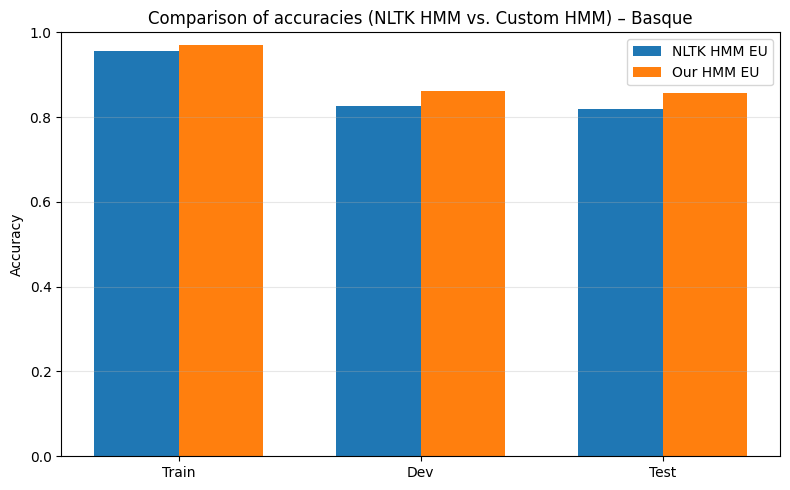

In [8]:
models = ["Train", "Dev", "Test"]
nltk_acc_eu = [acc_train_nltk_eu, acc_dev_nltk_eu, acc_test_nltk_eu]
ours_acc_eu = [acc_train_ours_eu, acc_dev_ours_eu, acc_test_ours_eu]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, nltk_acc_eu, width, label="NLTK HMM EU")
plt.bar(x + width/2, ours_acc_eu, width, label="Our HMM EU")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Comparison of accuracies (NLTK HMM vs. Custom HMM) – Basque")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "hmm_accuracy_eu.png", dpi=300, bbox_inches="tight")
plt.show()


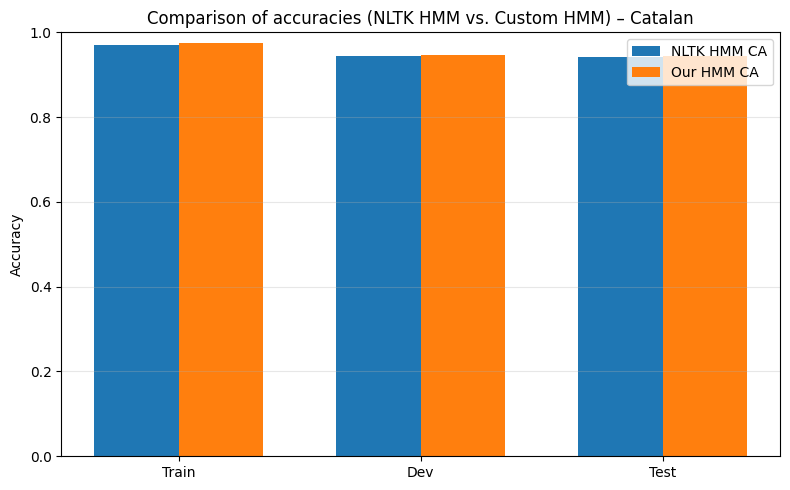

In [9]:
nltk_acc_ca = [acc_train_nltk_ca, acc_dev_nltk_ca, acc_test_nltk_ca]
ours_acc_ca = [acc_train_ours_ca, acc_dev_ours_ca, acc_test_ours_ca]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, nltk_acc_ca, width, label="NLTK HMM CA")
plt.bar(x + width/2, ours_acc_ca, width, label="Our HMM CA")

plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Comparison of accuracies (NLTK HMM vs. Custom HMM) – Catalan")
plt.ylim(0,1)
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "hmm_accuracy_ca.png", dpi=300, bbox_inches="tight")
plt.show()


Once trained, the HMM can assign POS tags to new sentences.  
It does so using the **Viterbi algorithm**, which finds the most probable tag sequence:

\[
Y^\* = \arg\max_Y P(X, Y)
\]

`tagger.best_path(sentence)` runs Viterbi internally and returns the optimal tag sequence.

In [10]:
# === Example EU ===
sentence_eu = "Gero , masa jarri molde batean .".split()

pred_nltk_eu  = tagger_eu.best_path(sentence_eu)
pred_ours_eu  = hmm_eu.viterbi(sentence_eu)

print("=== NLTK HMM (EU) ===")
print(list(zip(sentence_eu, pred_nltk_eu)))

print("=== Our HMM (EU) ===")
print(list(zip(sentence_eu, pred_ours_eu)))


=== NLTK HMM (EU) ===
[('Gero', 'ADV'), (',', 'PUNCT'), ('masa', 'NOUN'), ('jarri', 'VERB'), ('molde', 'NOUN'), ('batean', 'NUM'), ('.', 'PUNCT')]
=== Our HMM (EU) ===
[('Gero', 'ADV'), (',', 'PUNCT'), ('masa', 'NOUN'), ('jarri', 'VERB'), ('molde', 'NOUN'), ('batean', 'NUM'), ('.', 'PUNCT')]


In [11]:
# === Example CA ===
sentence_ca = "Després , la massa es posa en un motlle .".split()

pred_nltk_ca  = tagger_ca.best_path(sentence_ca)
pred_ours_ca  = hmm_ca.viterbi(sentence_ca)

print("=== NLTK HMM (CA) ===")
print(list(zip(sentence_ca, pred_nltk_ca)))

print("=== Our HMM (CA) ===")
print(list(zip(sentence_ca, pred_ours_ca)))


=== NLTK HMM (CA) ===
[('Després', 'ADV'), (',', 'PUNCT'), ('la', 'DET'), ('massa', 'NOUN'), ('es', 'PRON'), ('posa', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('motlle', 'NOUN'), ('.', 'PUNCT')]
=== Our HMM (CA) ===
[('Després', 'ADV'), (',', 'PUNCT'), ('la', 'DET'), ('massa', 'NOUN'), ('es', 'PRON'), ('posa', 'VERB'), ('en', 'ADP'), ('un', 'DET'), ('motlle', 'NOUN'), ('.', 'PUNCT')]


HMMs are generative models.  
They allow us to compute the joint probability of a specific word–tag sequence:

\[
P(X, Y)
\]

This combined likelihood is useful for:

- analysing how well a proposed tagging fits a sentence  
- comparing multiple candidate taggings  
- exploring the syntactic plausibility of sequences

The function `tagger.probability()` computes:

\[
P((x_1,y_1), \dots, (x_n,y_n))
\]

In [12]:
tagger = tagger_eu  # we are gonna use the hmm of basque for this example

sent = "Gero masa jarri .".split()
tags = ["ADV", "NOUN", "VERB", "PUNCT"]

comb = list(zip(sent, tags))
print("Probability (EU):", tagger.probability(comb))


Probability (EU): 4.2920479139869727e-13


Since an HMM models the full joint distribution \(P(X, Y)\), it can also *generate* new word–tag sequences by sampling from:

- the initial state distribution  
- the transition probabilities  
- the emission probabilities  

This produces synthetic sentences following the structure the model has learned.

Sampling illustrates how the HMM internally represents patterns in the data.

In [13]:
rng = np.random.default_rng()

sample = tagger_eu.random_sample(rng=rng, length=10)
print(sample)


[('batua', 'ADJ'), ('JiKoo', 'VERB'), ('.', 'PUNCT'), ('.', 'PUNCT'), ('Arabako', 'PROPN'), ('soka', 'NOUN'), ('itzuli', 'VERB'), (',', 'PUNCT'), ('txartela', 'NOUN'), ('ezkontzea', 'VERB')]


### 3.2 Precision, recall and F1-score

In [14]:
pred_nltk_eu = []
for sent in test_sentences:
    tagged_sent = tagger_eu.tag(sent)
    tags_only = [tag for (word, tag) in tagged_sent]
    pred_nltk_eu.extend(tags_only)

pred_nltk_ca = []
for sent in test_sentences_ca:
    tagged_sent = tagger_ca.tag(sent)
    tags_only = [tag for (word, tag) in tagged_sent]
    pred_nltk_ca.extend(tags_only)

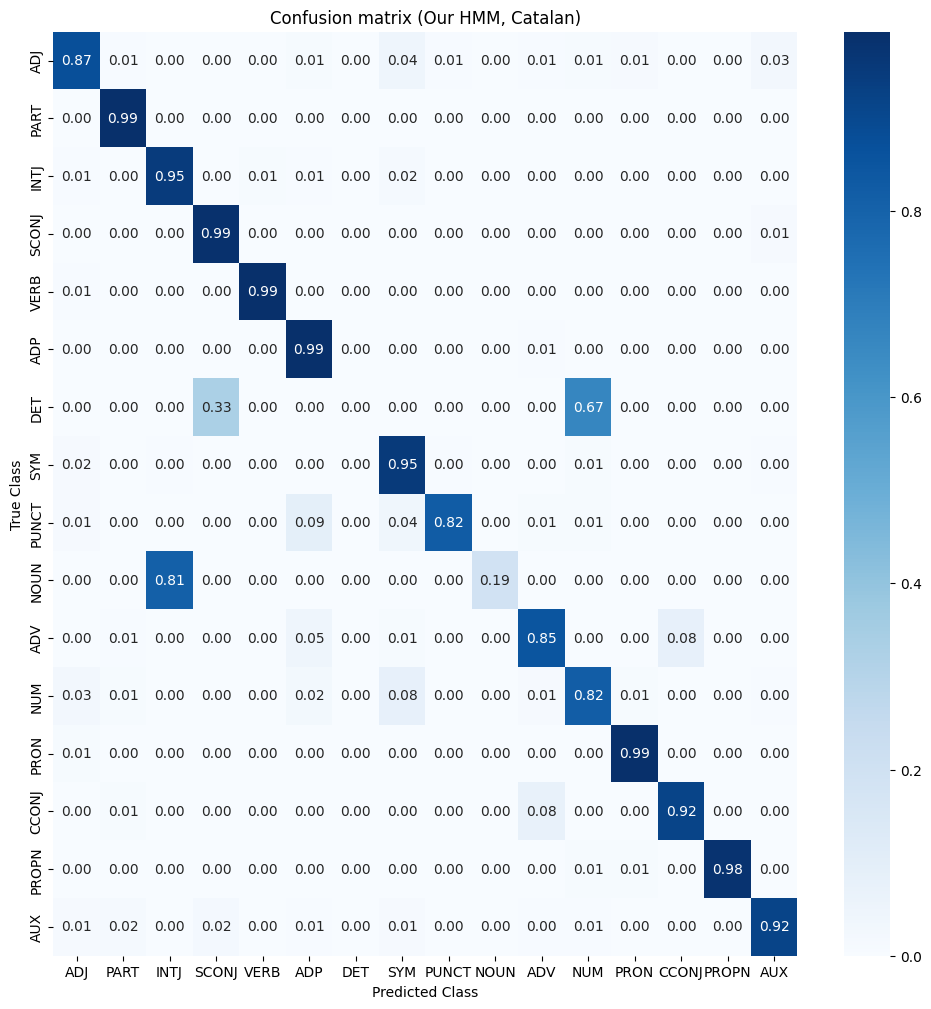

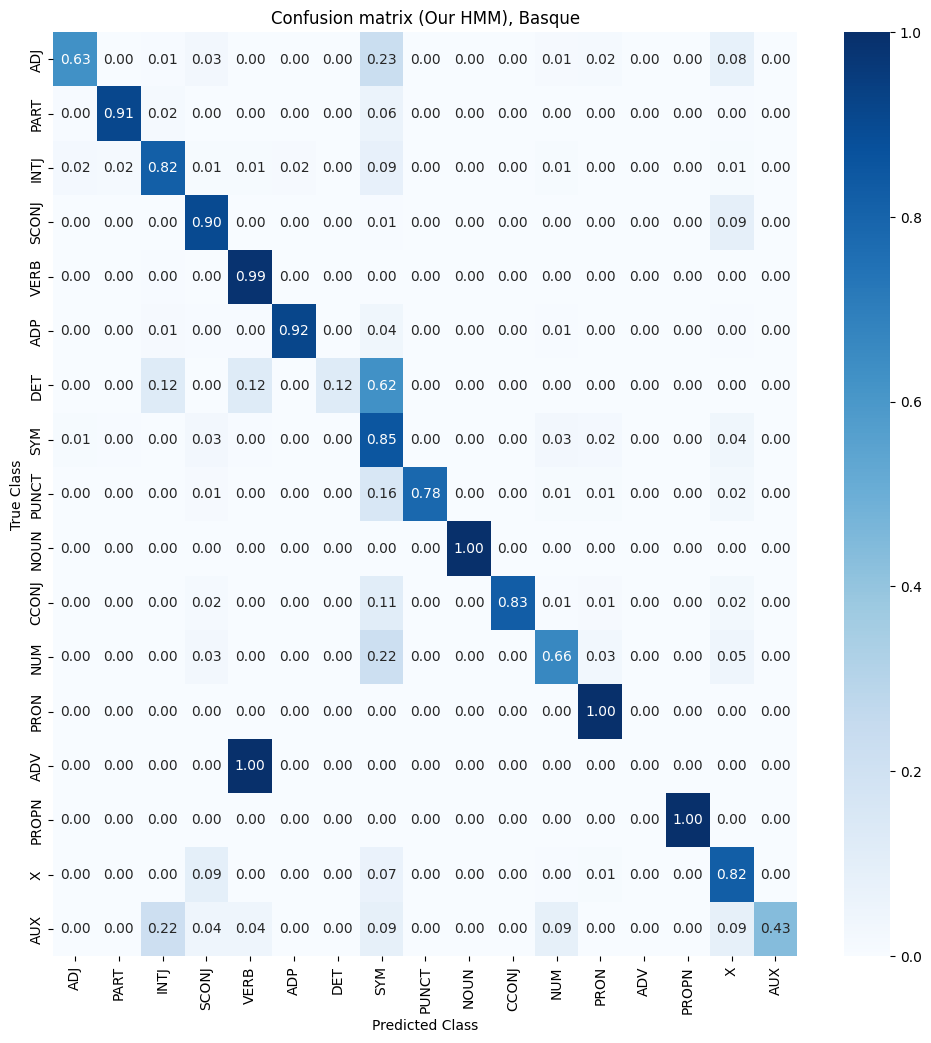

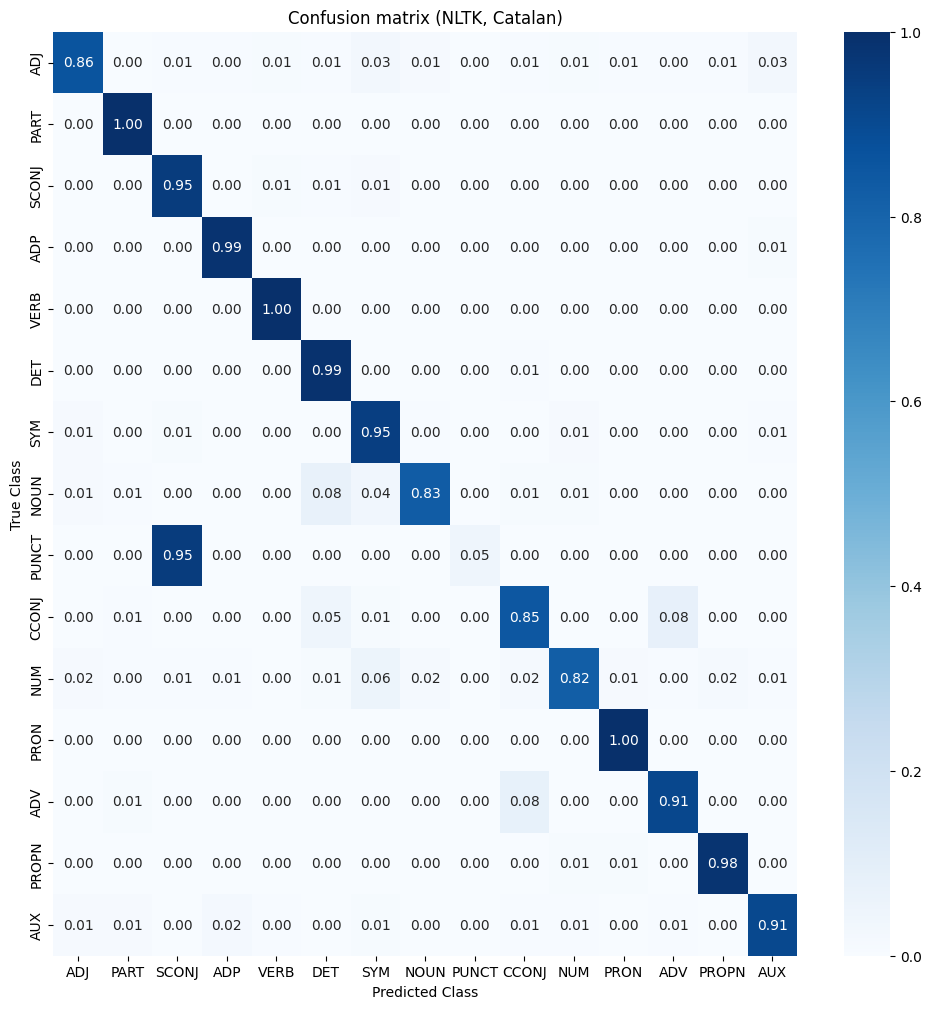

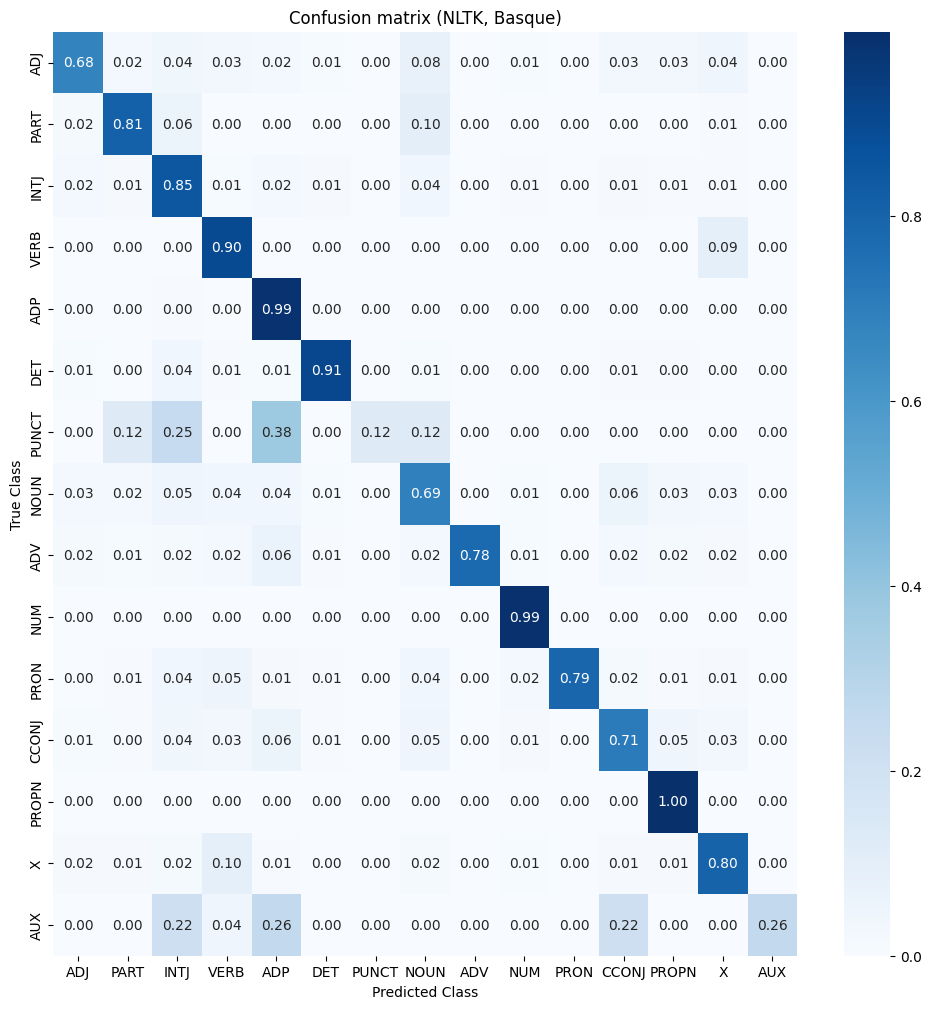

In [ ]:
#### Confusion-matrix
gold_all_ca, pred_all_ca = plots.tag_whole_test(hmm_ca, test_sentences_ca, test_tags_ca)
gold_all_eu, pred_all_eu = plots.tag_whole_test(hmm_eu, test_sentences, test_tags)

cm_hmm_ca = plots.confusion_matrix(gold_all_ca, pred_all_ca, hmm_ca.tags, title= 'Confusion matrix (Our HMM, Catalan)')
cm_hmm_eu = plots.confusion_matrix(gold_all_eu, pred_all_eu, hmm_eu.tags, title='Confusion matrix (Our HMM, Basque)')

cm_nltk_ca = plots.confusion_matrix(gold_all_ca, pred_nltk_ca, set(pred_nltk_ca), title='Confusion matrix (NLTK, Catalan)')
cm_nltk_eu = plots.confusion_matrix(gold_all_eu, pred_nltk_eu, set(pred_nltk_eu), title='Confusion matrix (NLTK, Basque)')


Grouped bar chart


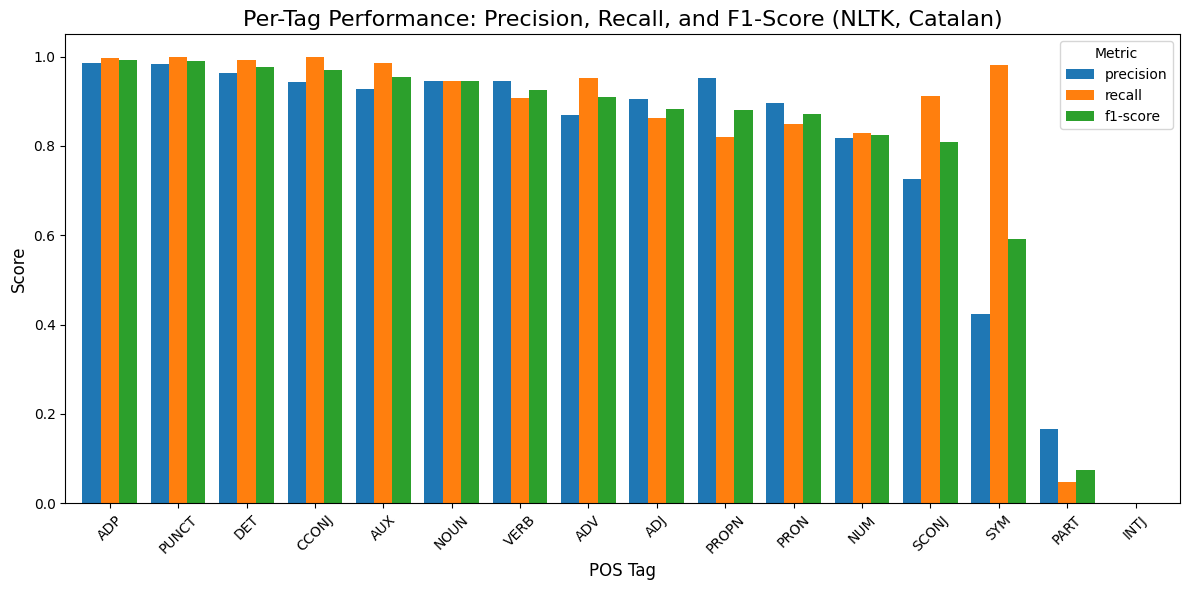

Grouped bar chart


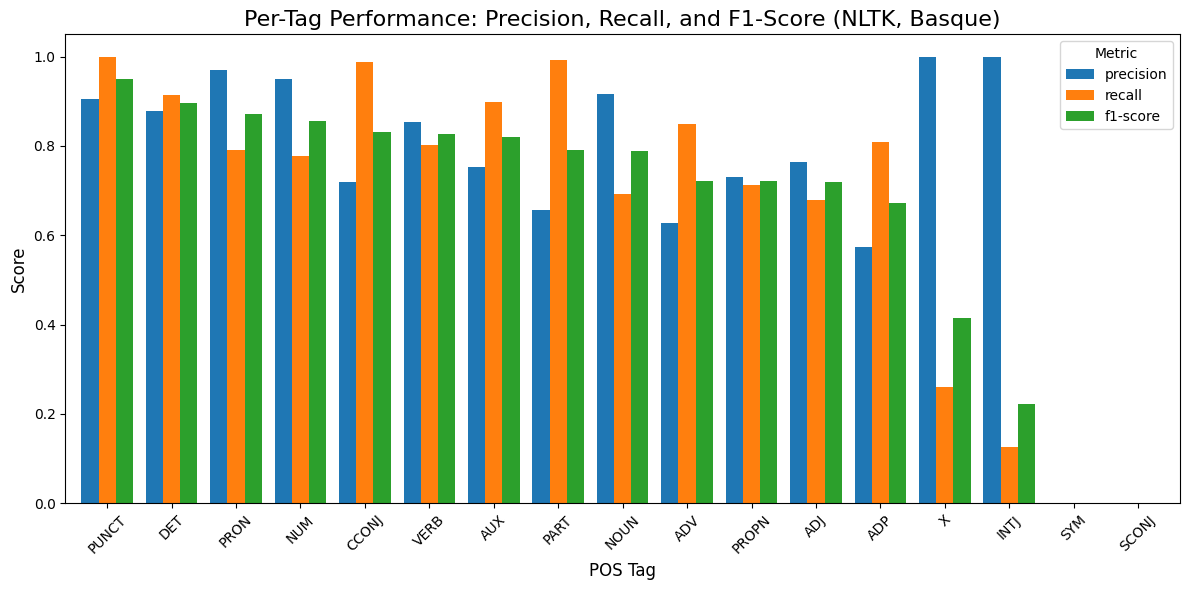

Grouped bar chart


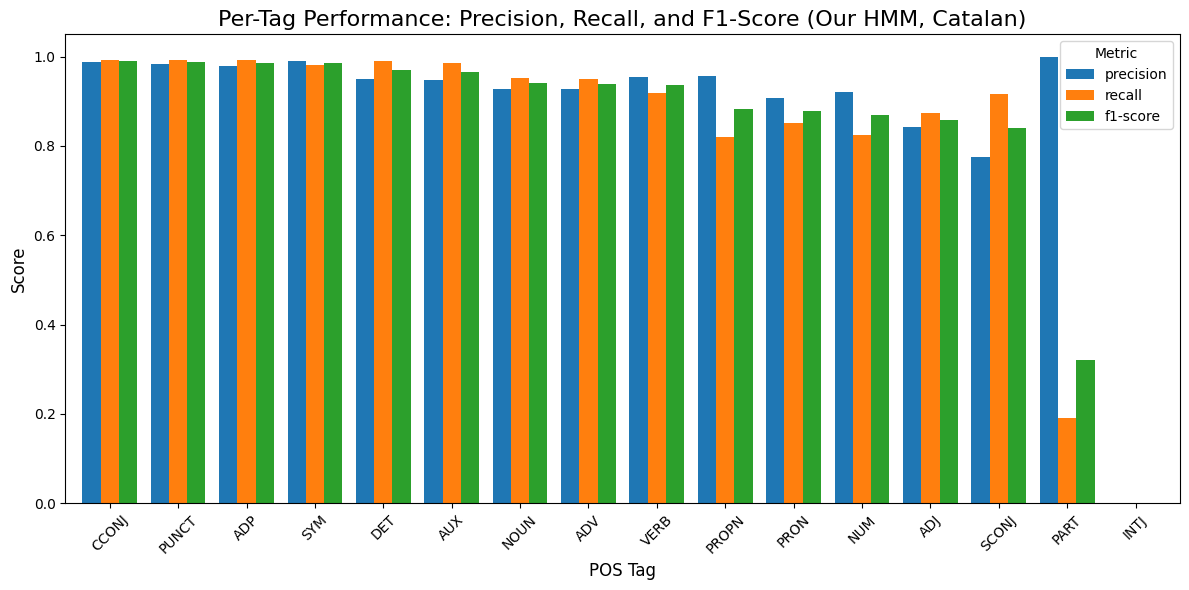

Grouped bar chart


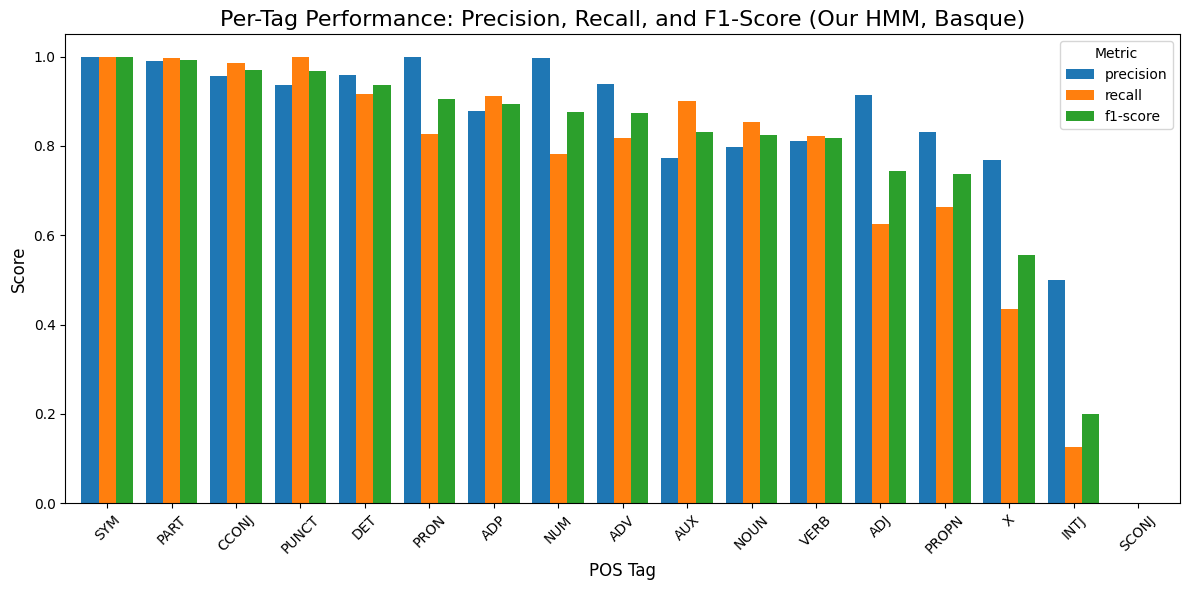

In [16]:
from sklearn.metrics import classification_report

report_nltk_ca = classification_report(gold_all_ca, pred_nltk_ca, output_dict=True, zero_division=0)
report_nltk_eu = classification_report(gold_all_eu, pred_nltk_eu, output_dict=True, zero_division=0)

report_our_ca = evaluate_per_tag(hmm_ca, test_sentences_ca, test_tags_ca)
report_our_eu = evaluate_per_tag(hmm_eu, test_sentences, test_tags)

plots.per_tag_metrics(report_nltk_ca, title='Per-Tag Performance: Precision, Recall, and F1-Score (NLTK, Catalan)')
plots.per_tag_metrics(report_nltk_eu, title='Per-Tag Performance: Precision, Recall, and F1-Score (NLTK, Basque)')
plots.per_tag_metrics(report_our_ca, title='Per-Tag Performance: Precision, Recall, and F1-Score (Our HMM, Catalan)')
plots.per_tag_metrics(report_our_eu, title='Per-Tag Performance: Precision, Recall, and F1-Score (Our HMM, Basque)')

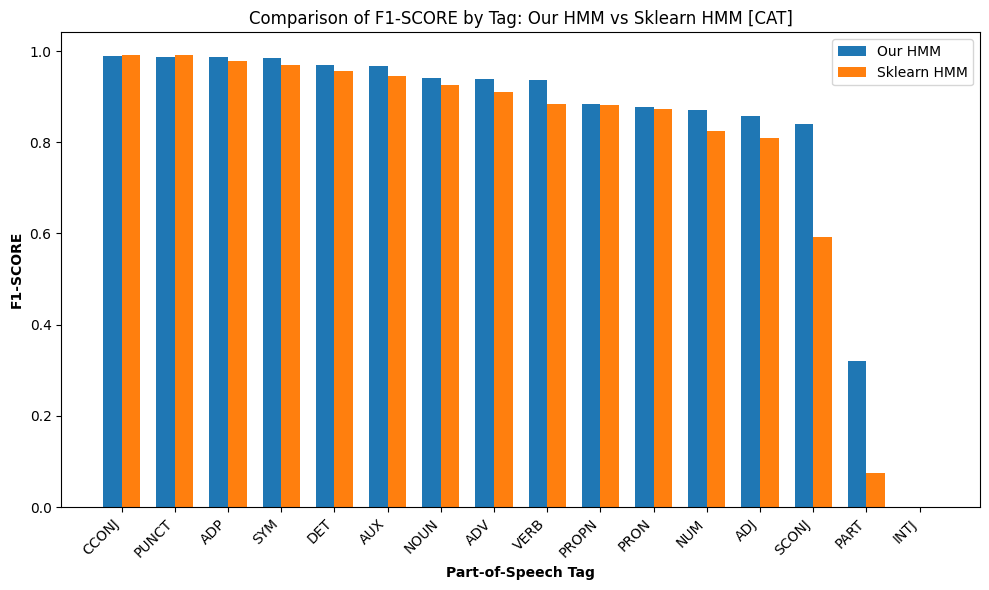

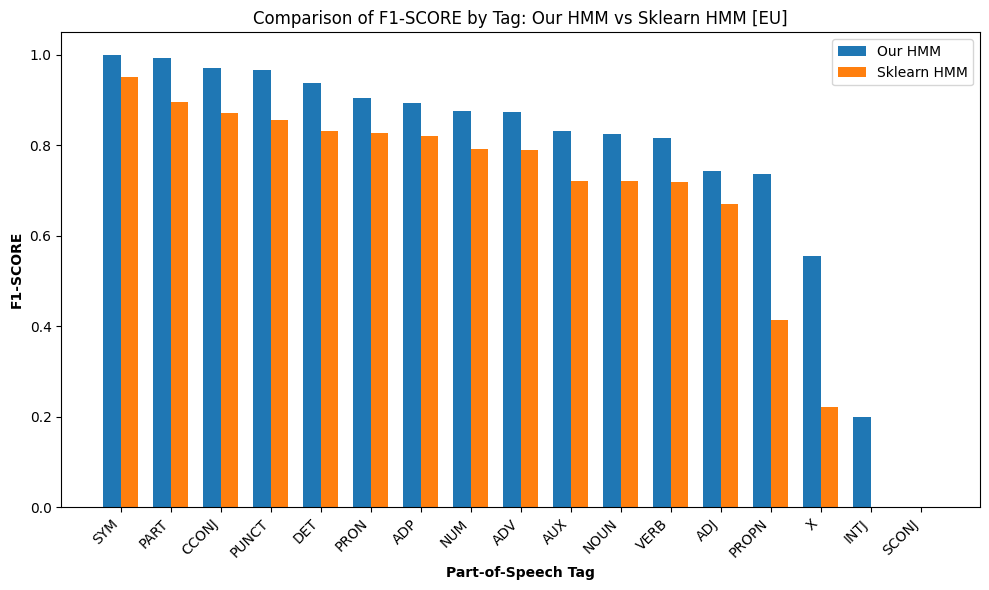

In [17]:
plots.compare_reports(report_our_ca, report_nltk_ca, language='CAT')
plots.compare_reports(report_our_eu, report_nltk_eu, language='EU')

# Supplementary
To compare the HMM with other POS-tagging strategies, we also implement several backoff n-gram taggers:

- **Default tagger:** assigns the same tag to every word  
- **Unigram tagger:** chooses the most frequent tag for each word  
- **Bigram tagger:** conditions on the previous tag  
- **Trigram tagger:** conditions on the previous two tags

If a trigram is unseen, the model *backs off* to the bigram model;  
if the bigram is unseen, it backs off to the unigram model;  
and finally to the default tagger.

This corresponds to the “Backoff Tagging & n-gram models” section of the theory.

We evaluate these taggers and compare their performance with the HMM.

In [18]:
# === N-gram taggers (Basque) ===
default_eu = nltk.DefaultTagger("NOUN")

uni_eu = nltk.UnigramTagger(labeled_train_eu, backoff=default_eu)
bi_eu  = nltk.BigramTagger(labeled_train_eu, backoff=uni_eu)
tri_eu = nltk.TrigramTagger(labeled_train_eu, backoff=bi_eu)

print("Unigram accuracy (EU):", uni_eu.accuracy(labeled_test_eu))
print("Bigram accuracy  (EU):", bi_eu.accuracy(labeled_test_eu))
print("Trigram accuracy (EU):", tri_eu.accuracy(labeled_test_eu))


# === N-gram taggers (Catalan) ===
default_ca = nltk.DefaultTagger("NOUN")

uni_ca = nltk.UnigramTagger(labeled_train_ca, backoff=default_ca)
bi_ca  = nltk.BigramTagger(labeled_train_ca, backoff=uni_ca)
tri_ca = nltk.TrigramTagger(labeled_train_ca, backoff=bi_ca)

print("Unigram accuracy (CA):", uni_ca.accuracy(labeled_test_ca))
print("Bigram accuracy  (CA):", bi_ca.accuracy(labeled_test_ca))
print("Trigram accuracy (CA):", tri_ca.accuracy(labeled_test_ca))


Unigram accuracy (EU): 0.8593993599737425
Bigram accuracy  (EU): 0.8662509231147945
Trigram accuracy (EU): 0.8655944859276278
Unigram accuracy (CA): 0.9207427461010812
Bigram accuracy  (CA): 0.9347107575279443
Trigram accuracy (CA): 0.9353086747828397


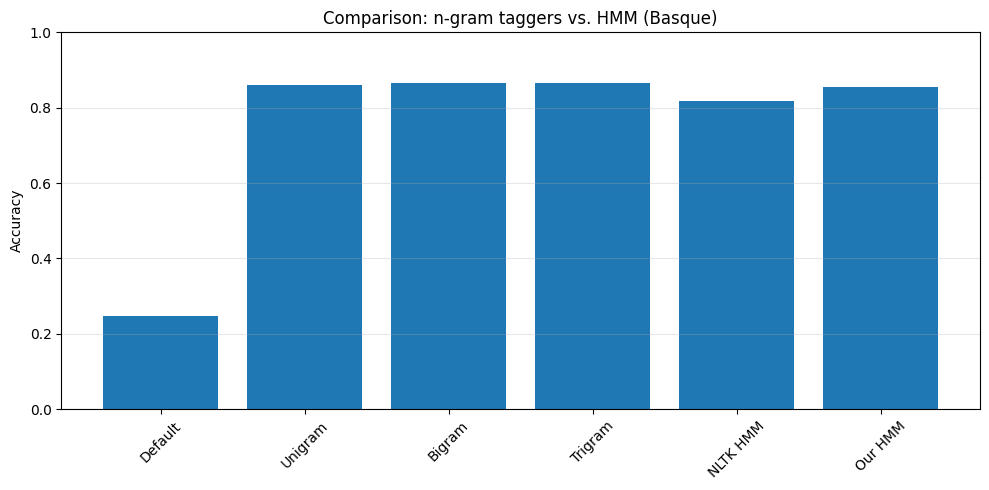

In [19]:
ngram_models = ["Default", "Unigram", "Bigram", "Trigram", "NLTK HMM", "Our HMM"]
ngram_acc = [
    default_eu.accuracy(labeled_test_eu),
    uni_eu.accuracy(labeled_test_eu),
    bi_eu.accuracy(labeled_test_eu),
    tri_eu.accuracy(labeled_test_eu),
    acc_test_nltk_eu,
    acc_test_ours_eu
]

plt.figure(figsize=(10,5))
plt.bar(ngram_models, ngram_acc)
plt.ylabel("Accuracy")
plt.title("Comparison: n-gram taggers vs. HMM (Basque)")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "ngram_vs_hmm_eu.png", dpi=300, bbox_inches="tight")
plt.show()


Error distribution by tag

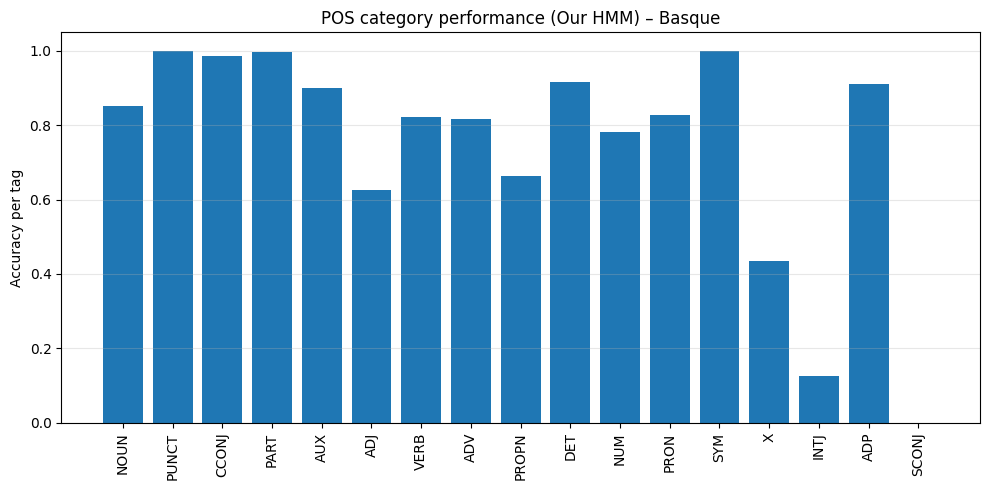

In [20]:
tag_acc_eu = per_tag_accuracy(hmm_eu, test_sentences, test_tags)

plt.figure(figsize=(10,5))
plt.bar(tag_acc_eu.keys(), tag_acc_eu.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy per tag")
plt.title("POS category performance (Our HMM) – Basque")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "pos_accuracy_eu.png", dpi=300, bbox_inches="tight")
plt.show()


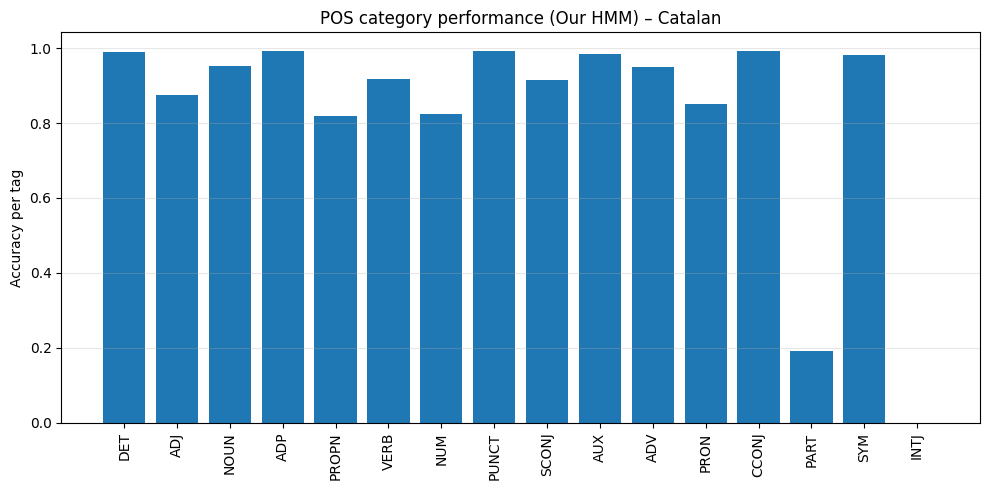

In [21]:
tag_acc_ca = per_tag_accuracy(hmm_ca, test_sentences_ca, test_tags_ca)

plt.figure(figsize=(10,5))
plt.bar(tag_acc_ca.keys(), tag_acc_ca.values())
plt.xticks(rotation=90)
plt.ylabel("Accuracy per tag")
plt.title("POS category performance (Our HMM) – Catalan")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.savefig(FIG_DIR / "pos_accuracy_ca.png", dpi=300, bbox_inches="tight")
plt.show()
